In [2]:
import torch
import cv2
from segment_anything import sam_model_registry, SamPredictor
from segment_anything import SamAutomaticMaskGenerator_mod2 as SamAutomaticMaskGenerator
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch
import functions as fnc
from importlib import reload
import gc
from skimage.measure import label, regionprops
from collections import Counter
from torchvision.ops.boxes import batched_nms
from sklearn.neighbors import KDTree
import matplotlib.colors as mcolors
import os
import time
from skimage.morphology import binary_dilation
import json
import sys
from tqdm import tqdm

In [3]:
#load image
init_para={'OutDIR': '/DATA/vito/output/Ravi2_fnc_dw8/',
      'DataDIR': '/DATA/vito/data/',
      'DatasetName': 'Ravi/*',
      'fid': 3,
      'crop_size': 1024,
      'resample_factor': 1,
      'dilation_size':15,
      'min_size_factor':0.001
      }

OutDIR=init_para.get('OutDIR')
DataDIR=init_para.get('DataDIR')
DSname=init_para.get('DatasetName')
fid=init_para.get('fid')
resample_factor=init_para.get('resample_factor')

#setup SAM
MODEL_TYPE = "vit_h"
#DEVICE, CHECKPOINT_PATH=fnc.set_sam(MODEL_TYPE, DataDIR)
#sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
#sam.to(device=DEVICE)
#mask_generator = SamAutomaticMaskGenerator(sam)

image=fnc.load_image(DataDIR,DSname,fid)
print('Image size:', image.shape)
if resample_factor!=1:
      pre_para={'Downsample': {'fxy':resample_factor},
            #'Gaussian': {'kernel size':3}
            #'CLAHE':{'clip limit':2}#,
            #'Downsample': {'fxy':4},
            #'Buffering': {'crop size': crop_size}
            }

      image=fnc.preprocessing_roulette(image, pre_para)
seg_ids=np.load(DataDIR+DSname[:-1]+'Ravi3_DEM_clip_07mm_segment_ids.npy', allow_pickle=True)
print('id mask shape: ',seg_ids.shape)
#image=fnc.resample_fnc(image,{'target_size': seg_ids.shape[::-1]})
print('Image resampled to: ', image.shape)
#removing edge ids
for id in np.unique(np.hstack([np.unique(seg_ids[0,:]),np.unique(seg_ids[-1,:]),np.unique(seg_ids[:,0]),np.unique(seg_ids[:,-1])])):
    seg_ids[seg_ids==id]=-1

Ravi3_orthomosaic_clip_02mm.tif imported
Image size: (28382, 32563, 3)
id mask shape:  (8110, 9304)
Image resampled to:  (28382, 32563, 3)


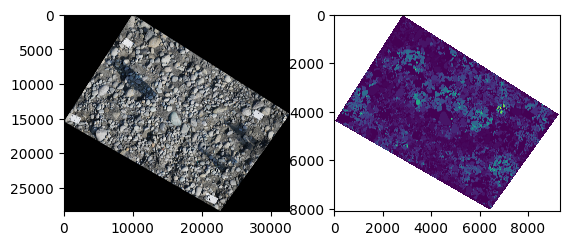

In [4]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(seg_ids)

In [3]:
pre_para={'Downsample': {'fxy':1/4},
        #'Gaussian': {'kernel size':3}
        #'CLAHE':{'clip limit':2}#,
        #'Downsample': {'fxy':4},
        #'Buffering': {'crop size': crop_size}
        }
image=fnc.preprocessing_roulette(image, pre_para)


Cropped from (7096, 8141, 3) to (512, 512, 3)


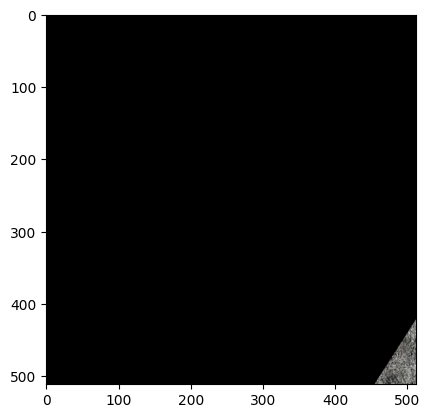

In [4]:
pre_para={'Crop': {'crop size': 512, 'j':3.3,'i':0},
                #'Gaussian': {'kernel size':3}
                #'CLAHE':{'clip limit':2}#,
                #'Downsample': {'fxy':4},
                #'Buffering': {'crop size': crop_size}
                }
temp_image=fnc.preprocessing_roulette(image, pre_para)
plt.imshow(temp_image)

In [5]:
mask_generator = SamAutomaticMaskGenerator(sam)
#SAM segmentation
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=48,
    pred_iou_thresh=0,
    stability_score_thresh=0,#iou by varying cutoff in binary conversion
    box_nms_thresh=0.3,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks
    crop_n_layers=0,#cut into 2**n crops
    crop_nms_thresh=0,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks between crops
    crop_n_points_downscale_factor=1,
    crop_overlap_ratio=0,
    #min_mask_region_area=2000,
)
predictor = SamPredictor(sam)
predictor.set_image(temp_image)

with torch.no_grad():
    masks = mask_generator.generate(temp_image)
print('First pass SAM: ', len(masks),' mask(s) found')

First pass SAM:  6912  mask(s) found


In [6]:
def filter_by_pred_iou_and_size_per_seedpoint(masks,size_threshold=0.4,crop_size=512):
    seed_point=np.array([mask['point_coords'][0] for mask in masks])
    highest_pred_iou_by_point=[]
    i=0
    while i < len(masks):
        i0=i
        if np.all(seed_point[i]==seed_point[i+2]):
            i+=2
        elif np.all(seed_point[i]==seed_point[i+1]):
            i+=1
        iou=[mask['predicted_iou'] for mask in masks[i0:i+1]]
        idx=np.argsort(iou)[::-1]
        pick=0

        while pick < len(idx):
            mask_area = np.sum(masks[idx[pick] + i0]['segmentation'])
            # if mask is very large compared to size of the image (credit:segment everygrain) modified from 0.1 to 0.4
            if mask_area / (crop_size ** 2) <= size_threshold:
                break
            else:
                pick += 1
        if pick<len(idx):
            highest_pred_iou_by_point.append(masks[idx[pick]+i0])
        i+=1
    return highest_pred_iou_by_point
masks=filter_by_pred_iou_and_size_per_seedpoint(masks)
print('Filtered by highest predicted iou per seed point, ', len(masks),' mask(s) remains')

Filtered by highest predicted iou per seed point,  2278  mask(s) remains


In [7]:
list_of_pred_iou = [mask['predicted_iou'] for mask in masks]
list_of_masks = [fnc.clean_mask(mask['segmentation'].astype('bool')) for mask in masks]

In [8]:
no_area_after_cleaning=np.array([np.sum(mask)==0 for mask in list_of_masks])


In [9]:
filtered_masks = [mask for mask, keep in zip(list_of_masks, ~no_area_after_cleaning) if keep]

In [10]:
print(len(list_of_masks),len(filtered_masks))

2278 2229


In [5]:
id_mask = np.zeros_like(image, dtype=np.uint16)
crop_size=4000
clipij=fnc.define_clips(image.shape[0],image.shape[1],resample_factor,crop_size,1)
all_clips=[]
for ij_idx in tqdm(clipij,'Clip'):
    start_loop = time.time()
    print(f'Segmenting clip: {ij_idx}')
    ji=ij_idx[1]
    ii=ij_idx[0]
    if (ji*crop_size<(image.shape[1]) and ii*crop_size<(image.shape[0])):
        #prepare image
        pre_para={'Crop': {'crop size': crop_size, 'j':ji,'i':ii},
                #'Gaussian': {'kernel size':3}
                #'CLAHE':{'clip limit':2}#,
                #'Downsample': {'fxy':4},
                #'Buffering': {'crop size': crop_size}
                }
        temp_image=fnc.preprocessing_roulette(image, pre_para)

        temp_seg_ids=fnc.preprocessing_roulette(seg_ids, pre_para)
        seg_labels=(np.unique(temp_seg_ids))
        seg_labels=seg_labels[seg_labels>=0]#remove backgeound label

        
        if len(seg_labels)>0:#if there is valid labels
            pointed_seg_resized=[]
            seg_size=[]
            for seg in seg_labels:
                seg_size.append(np.sum(temp_seg_ids==seg))
            seg_size_sort_idx=np.argsort(seg_size)

            list_of_label_centroid = [fnc.get_centroid((temp_seg_ids==seg_labels[index]).astype('bool')) for index in seg_size_sort_idx]
            
            #clear gpu ram and setup sam
            gc.collect()
            torch.cuda.empty_cache()
            sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
            sam.to(device=DEVICE)
            predictor = SamPredictor(sam)
            predictor.set_image(temp_image)
            all_resize=[]
            all_score=[]            
            for i,centroid in tqdm(enumerate(list_of_label_centroid), 'Label centroid', leave=False, total=len(list_of_label_centroid)):
                y0, x0 =centroid
                input_point = np.array([[int(x0),int(y0)]])
                input_label = np.array([1])

                gc.collect()
                torch.cuda.empty_cache()

                partmasks, scores, logits = predictor.predict(
                    point_coords=input_point,
                    point_labels=input_label,
                    multimask_output=True,)
                best_idx=np.argmax(scores)#pick the mask with highest score
                mask=partmasks[best_idx]
                score=scores[best_idx]
            
                #resize
                #if not (np.any(mask[0]==1) or np.any(mask[-1]==1) or np.any(mask[:,0]==1) or np.any(mask[:,-1]==1)):
                resize=np.zeros(image.shape[:-1])
                Valid_area=resize[int(crop_size*ii):int(crop_size*ii+crop_size),int(crop_size*ji):int(crop_size*ji+crop_size)].shape
                if Valid_area==(crop_size,crop_size):
                    resize[int(crop_size*ii):int(crop_size*ii+crop_size),int(crop_size*ji):int(crop_size*ji+crop_size)]=mask
                else:
                    resize[int(crop_size*ii):int(crop_size*ii+crop_size),int(crop_size*ji):int(crop_size*ji+crop_size)]=mask[:Valid_area[0],:Valid_area[1]]
                #resize=fnc.resample_fnc(resize,{'target_size':image.shape[:-1][::-1]}).astype('bool')
                all_resize.append(mask.astype('bool'))
                all_score.append(score)

                id_mask[resize.astype('bool')] = seg_labels[seg_size_sort_idx[i]]
            np.save(DataDIR+DSname[:-1]+'label/Ravi3_label_pointed_seg_id',id_mask)

            pointed_seg_resized.append({'mask':all_resize,'predicted_iou':all_score,
                                        'crop_size':crop_size,'i':ii,'j':ji})
            np.save(DataDIR+DSname[:-1]+'label/Ravi3_label_pointed_seg',np.hstack(pointed_seg_resized))

Clip:   0%|          | 0/9 [00:00<?, ?it/s]

Segmenting clip: [0 0]
Cropped from (8110, 9304, 3) to (4000, 4000, 3)
Cropped from (8110, 9304) to (4000, 4000)


Clip:  11%|█         | 1/9 [05:54<47:18, 354.87s/it]

Segmenting clip: [0 1]
Cropped from (8110, 9304, 3) to (4000, 4000, 3)
Cropped from (8110, 9304) to (4000, 4000)


Clip:  22%|██▏       | 2/9 [13:16<47:20, 405.79s/it]

Segmenting clip: [0 2]
Cropped from (8110, 9304, 3) to (4000, 1304, 3)
Cropped from (8110, 9304) to (4000, 1304)


Clip:  33%|███▎      | 3/9 [13:31<22:43, 227.25s/it]

Segmenting clip: [1 0]
Cropped from (8110, 9304, 3) to (4000, 4000, 3)
Cropped from (8110, 9304) to (4000, 4000)


Clip:  44%|████▍     | 4/9 [23:28<31:06, 373.35s/it]

Segmenting clip: [1 1]
Cropped from (8110, 9304, 3) to (4000, 4000, 3)
Cropped from (8110, 9304) to (4000, 4000)


Clip:  56%|█████▌    | 5/9 [39:42<39:19, 589.98s/it]

Segmenting clip: [1 2]
Cropped from (8110, 9304, 3) to (4000, 1304, 3)
Cropped from (8110, 9304) to (4000, 1304)


Clip:  78%|███████▊  | 7/9 [40:32<09:07, 273.55s/it]

Segmenting clip: [2 0]
Cropped from (8110, 9304, 3) to (110, 4000, 3)
Cropped from (8110, 9304) to (110, 4000)
Segmenting clip: [2 1]
Cropped from (8110, 9304, 3) to (110, 4000, 3)
Cropped from (8110, 9304) to (110, 4000)


Clip: 100%|██████████| 9/9 [40:37<00:00, 270.88s/it]

Segmenting clip: [2 2]
Cropped from (8110, 9304, 3) to (110, 1304, 3)
Cropped from (8110, 9304) to (110, 1304)


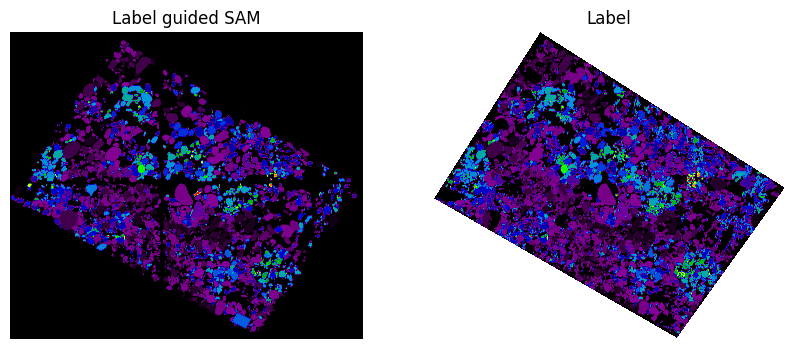

In [73]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(id_mask[:,:,0], cmap='nipy_spectral')
plt.title('Label guided SAM')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(seg_ids, cmap='nipy_spectral')
plt.axis('off')
plt.title('Label')
plt.savefig(DataDIR+DSname[:-1]+'label/Ravi3_labelvsguidedsam_vis.png')

In [28]:
len(np.unique(seg_ids))

4636

In [20]:
len(np.unique(id_mask))

3355

In [29]:
seg_ids_stats=fnc.create_stats_df(seg_ids)

In [43]:
seg_ids_stats.drop(seg_ids_stats[seg_ids_stats['label'] == -1].index, inplace=True)

In [45]:
seg_ids_stats.to_hdf(DataDIR+DSname[:-1]+'label/Ravi3_label_stats_df.h5', key='df', mode='w')

/tmp/ipykernel_204481/3487240552.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['bbox'], dtype='object')]

  seg_ids_stats.to_hdf(DataDIR+DSname[:-1]+'label/Ravi3_label_stats_df.h5', key='df', mode='w')


In [27]:
id_mask_stats=fnc.create_stats_df(id_mask[:,:,0])


/tmp/ipykernel_204481/2334917420.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['bbox'], dtype='object')]

  id_mask_stats.to_hdf(DataDIR+DSname[:-1]+'Ravi3_stats_df.h5', key='df', mode='w')


In [49]:
id_mask_stats.drop(id_mask_stats[id_mask_stats['label'] == 0].index, inplace=True)

In [51]:
id_mask_stats.to_hdf(DataDIR+DSname[:-1]+'label/Ravi3_stats_df.h5', key='df', mode='w')

/tmp/ipykernel_204481/3928345271.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['bbox'], dtype='object')]

  id_mask_stats.to_hdf(DataDIR+DSname[:-1]+'label/Ravi3_stats_df.h5', key='df', mode='w')


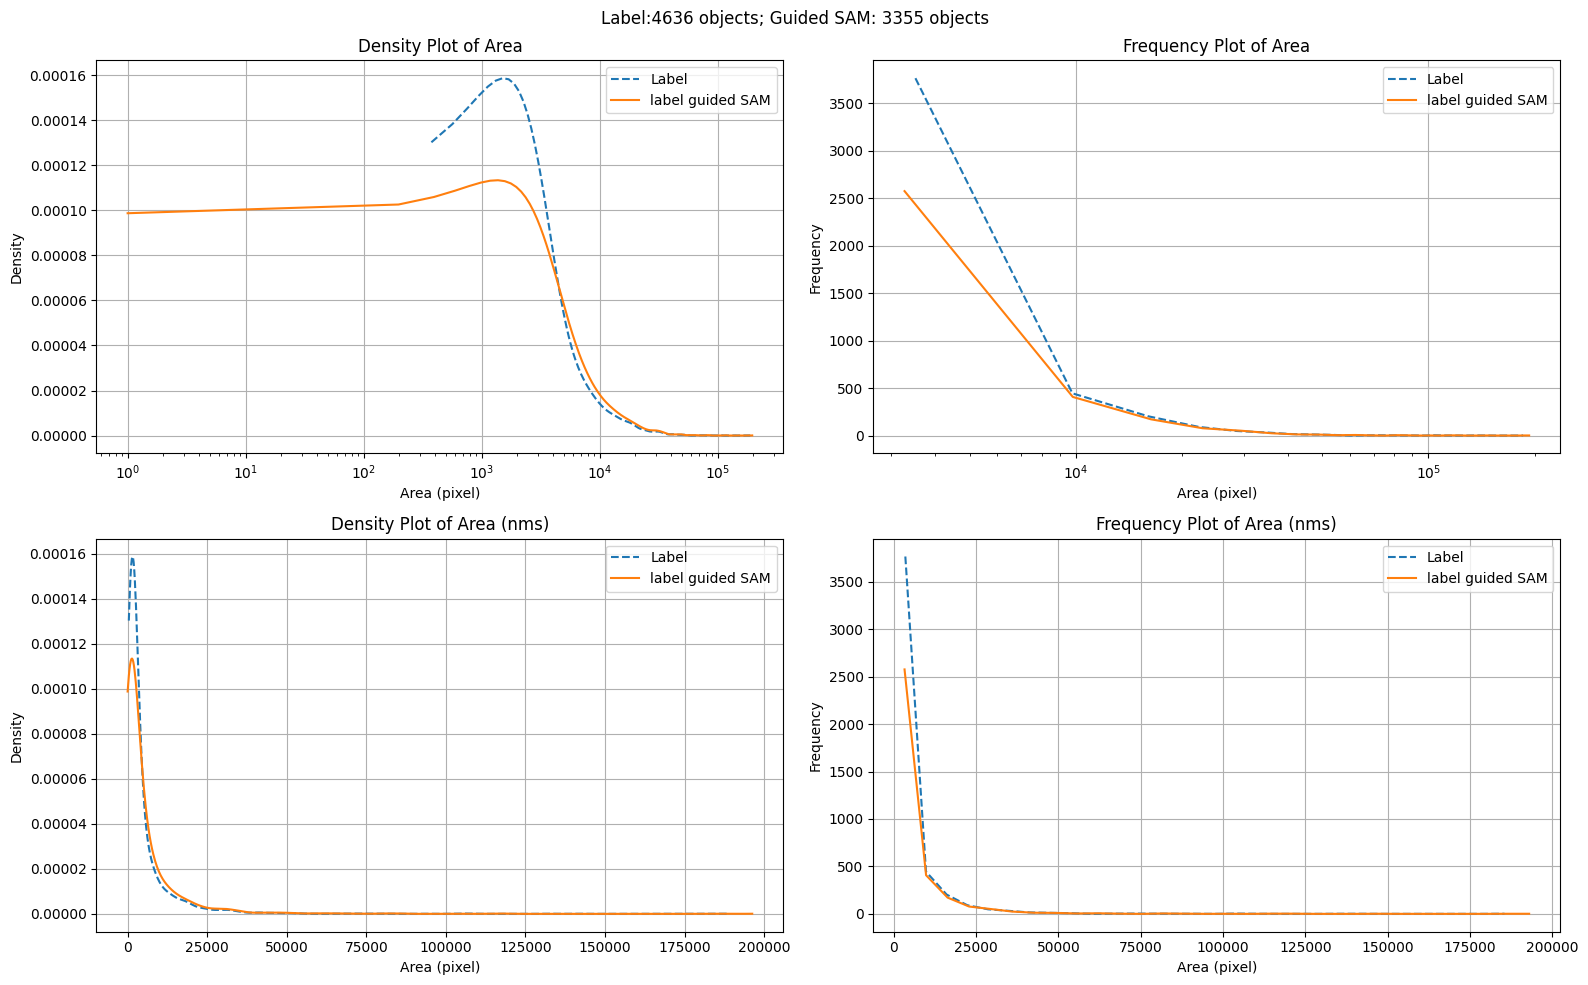

In [57]:
from scipy.stats import gaussian_kde
loged = True 

plt.figure(figsize=(16, 10))

labels=['Label','label guided SAM']
c=0

plt.subplot(2,2,1)
for df in [seg_ids_stats,id_mask_stats]:
    if loged:
        plt.xscale('log')
    data = df['area']

    kde = gaussian_kde(data)
    x = np.linspace(min(data), max(data), 1000)
    kde_values = kde(x)
    if c>2:
        plt.plot(x, kde_values, '--', label=labels[c], alpha=0.6)
    elif c>0:
        plt.plot(x, kde_values, label=labels[c])
    else:
        plt.plot(x, kde_values,'--', label=labels[c])
    c+=1

plt.xlabel('Area (pixel)')
plt.ylabel('Density')
plt.title('Density Plot of Area')
plt.legend(loc='upper right')
plt.grid()

plt.subplot(2,2,2)
loged = True
c=0
for df in [seg_ids_stats,id_mask_stats]:
    if loged:
        plt.xscale('log')
        #plt.yscale('log')
    data = df['area']

    frequencies, bin_edges = np.histogram(data, bins=30)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    if c>2:
        plt.plot(bin_midpoints, frequencies, '--', label=labels[c], alpha=0.6)
    elif c>0:
        plt.plot(bin_midpoints, frequencies, label=labels[c])
    else:
        plt.plot(bin_midpoints, frequencies, '--', label=labels[c])
    c+=1

plt.xlabel('Area (pixel)')
plt.ylabel('Frequency')
plt.title('Frequency Plot of Area')
plt.legend()
plt.grid()

c=0
loged=False
plt.subplot(2,2,3)
for df in [seg_ids_stats,id_mask_stats]:
    if loged:
        plt.xscale('log')
    data = df['area']

    kde = gaussian_kde(data)
    x = np.linspace(min(data), max(data), 1000)
    kde_values = kde(x)
    if c>2:
        plt.plot(x, kde_values, '--', label=labels[c], alpha=0.6)
    elif c>0:
        plt.plot(x, kde_values, label=labels[c])
    else:
        plt.plot(x, kde_values,'--', label=labels[c])
    c+=1

plt.xlabel('Area (pixel)')
plt.ylabel('Density')
plt.title('Density Plot of Area (nms)')
plt.legend(loc='upper right')
plt.grid()

plt.subplot(2,2,4)
loged = False
c=0
for df in [seg_ids_stats,id_mask_stats]:
    if loged:
        #plt.xscale('log')
        plt.yscale('log')
    data = df['area']

    frequencies, bin_edges = np.histogram(data, bins=30)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    if c>2:
        plt.plot(bin_midpoints, frequencies, '--', label=labels[c], alpha=0.6)
    elif c>0:
        plt.plot(bin_midpoints, frequencies, label=labels[c])
    else:
        plt.plot(bin_midpoints, frequencies, '--', label=labels[c])
    c+=1

plt.xlabel('Area (pixel)')
plt.ylabel('Frequency')
plt.title('Frequency Plot of Area (nms)')
plt.legend()
plt.grid()
plt.suptitle(f'Label:{ len(np.unique(seg_ids))} objects; Guided SAM: {len(np.unique(id_mask))} objects')
plt.tight_layout()
plt.savefig(DataDIR+DSname[:-1]+'label/Ravi3_labelvsguidedsam_stats.png')
plt.show()

In [3]:
id_mask=np.load(DataDIR+DSname[:-1]+'label/Ravi3_label_pointed_seg_id.npy')

In [4]:
id_mask_ids=np.unique(id_mask[:,:,0])
label_area_list=[]
iou_list=[]
for i in id_mask_ids:
    iou = fnc.iou(id_mask[:,:,0]==i,seg_ids==i)
    if np.sum(id_mask[:,:,0]==i)>=np.sum(seg_ids==i):
        iou_list.append(iou)
    else:
        iou_list.append(-iou)
    label_area_list.append(np.sum(seg_ids==i))

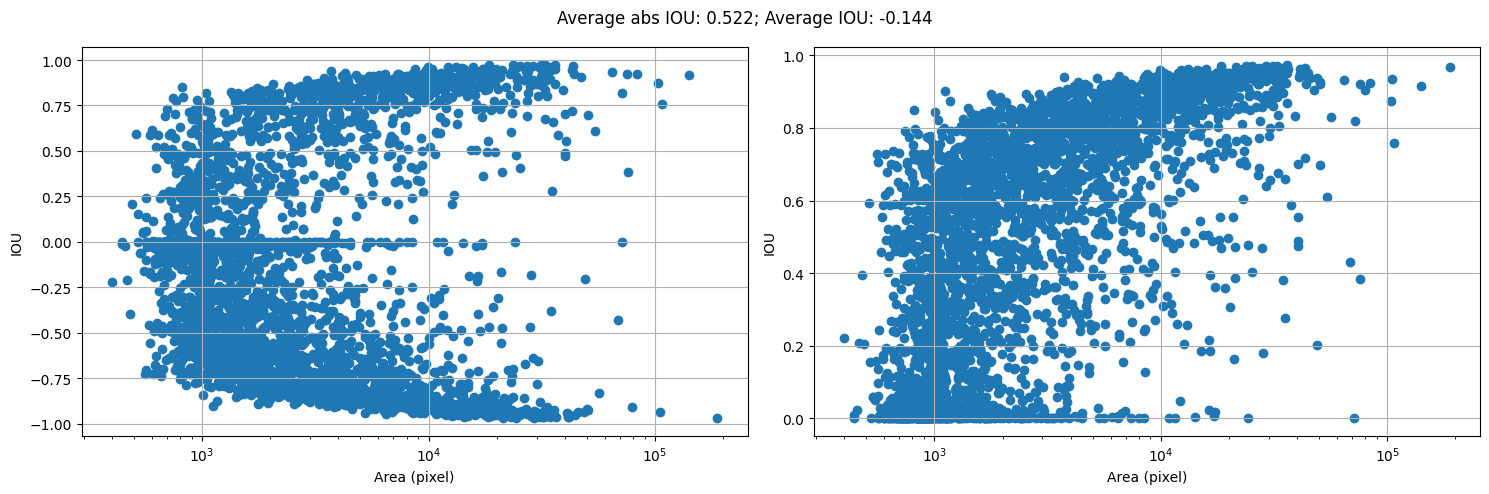

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.xscale('log')
plt.scatter(label_area_list[1:],iou_list[1:])
plt.xlabel('Area (pixel)')
plt.ylabel('IOU')
plt.grid()
plt.subplot(1,2,2)
plt.xscale('log')
plt.scatter(label_area_list[1:],np.abs(iou_list[1:]))
plt.xlabel('Area (pixel)')
plt.ylabel('IOU')
plt.grid()
plt.suptitle(f'Average abs IOU: {np.mean(np.abs(iou_list[1:])):.3f}; Average IOU: {(np.mean(iou_list[1:])):.3f}')
plt.tight_layout()
plt.savefig(DataDIR+DSname[:-1]+'label/Ravi3_labelvsguidedsam_iou.png')


In [4]:
seg_labels=(np.unique(seg_ids)[1:])

seg_size=[]
for seg in seg_labels:
    seg_size.append(np.sum(seg_ids==seg))

seg_size_sort_idx=np.argsort(seg_size)

#list_of_label=[(seg_ids==seg_labels[index]).astype('bool') for index in seg_size_sort_idx]
list_of_label_centroid = [fnc.get_centroid((seg_ids==seg_labels[index]).astype('bool')) for index in seg_size_sort_idx]


  0%|          | 0/4635 [00:00<?, ?it/s]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 1/4635 [00:17<23:03:52, 17.92s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 2/4635 [00:22<13:17:38, 10.33s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 2/4635 [00:27<17:53:20, 13.90s/it]


AttributeError: module 'functions' has no attribute 'downsample_fnc'

In [15]:
id_mask = np.zeros_like(seg_ids, dtype=np.uint16)
#clear gpu ram and setup sam
crop_size=2048

pointed_seg_resized=[]
for i,centroid in tqdm(enumerate(list_of_label_centroid), total=len(list_of_label_centroid), leave=False):
    y0, x0 =centroid
    xmin,ymin=x0-crop_size/2,y0-crop_size/2
    ji=xmin/crop_size
    ii=ymin/crop_size
    if ji<0:
        ji=0
    if ii<0:
        ii=0

    #prepare image
    pre_para={'Crop': {'crop size': crop_size, 'j':ji,'i':ii}}
    temp_image=fnc.preprocessing_roulette(image, pre_para)

    #clear gpu ram and setup sam
    gc.collect()
    torch.cuda.empty_cache()
    sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
    sam.to(device=DEVICE)
    predictor = SamPredictor(sam)
    predictor.set_image(temp_image)

    input_point = np.array([[int(x0-xmin),int(y0-ymin)]])
    input_label = np.array([1])

    gc.collect()
    torch.cuda.empty_cache()

    partmasks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,)
    best_idx=np.argmax(scores)#pick the mask with highest score
    mask=partmasks[best_idx].astype('bool')
            
    #for mask in void_pointed_reseg:
    if not (np.any(mask[0]==1) or np.any(mask[-1]==1) or np.any(mask[:,0]==1) or np.any(mask[:,-1]==1)):
        resize=np.zeros(image.shape[:-1])
        Valid_area=resize[int(crop_size*ii):int(crop_size*ii+crop_size),int(crop_size*ji):int(crop_size*ji+crop_size)].shape
        if Valid_area==(crop_size,crop_size):
            resize[int(crop_size*ii):int(crop_size*ii+crop_size),int(crop_size*ji):int(crop_size*ji+crop_size)]=mask
        else:
            resize[int(crop_size*ii):int(crop_size*ii+crop_size),int(crop_size*ji):int(crop_size*ji+crop_size)]=mask[:Valid_area[0],:Valid_area[1]]
        #resize=fnc.resample_fnc(resize,{'target_size':image.shape[:-1][::-1]}).astype('bool')
        id_mask[resize.astype('bool')] = seg_labels[seg_size_sort_idx[i]]
        pointed_seg_resized.append(resize.astype('bool'))

  0%|          | 0/4635 [00:00<?, ?it/s]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 1/4635 [00:04<6:07:22,  4.76s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 2/4635 [00:09<6:05:47,  4.74s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 3/4635 [00:14<6:11:32,  4.81s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 4/4635 [00:19<6:14:09,  4.85s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 5/4635 [00:24<6:15:28,  4.87s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 6/4635 [00:28<6:11:28,  4.82s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 7/4635 [00:33<6:13:32,  4.84s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 8/4635 [00:38<6:14:51,  4.86s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 9/4635 [00:43<6:15:45,  4.87s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 10/4635 [00:48<6:16:52,  4.89s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 11/4635 [00:53<6:12:43,  4.84s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 12/4635 [00:57<6:10:13,  4.81s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 13/4635 [01:02<6:12:48,  4.84s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 14/4635 [01:07<6:14:45,  4.87s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 15/4635 [01:12<6:15:39,  4.88s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 16/4635 [01:17<6:12:24,  4.84s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 17/4635 [01:22<6:13:56,  4.86s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 18/4635 [01:27<6:11:04,  4.82s/it]

Cropped from (8110, 9304, 3) to (1453, 2048, 3)


  0%|          | 19/4635 [01:31<6:08:40,  4.79s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 20/4635 [01:36<6:11:49,  4.83s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 21/4635 [01:41<6:13:57,  4.86s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 22/4635 [01:46<6:15:20,  4.88s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  0%|          | 23/4635 [01:51<6:16:20,  4.90s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 24/4635 [01:56<6:16:57,  4.91s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 25/4635 [02:01<6:17:51,  4.92s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 26/4635 [02:06<6:13:39,  4.86s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 27/4635 [02:11<6:15:05,  4.88s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 28/4635 [02:16<6:16:05,  4.90s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 29/4635 [02:20<6:16:49,  4.91s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 30/4635 [02:25<6:17:12,  4.91s/it]

Cropped from (8110, 9304, 3) to (1831, 2048, 3)


  1%|          | 31/4635 [02:30<6:17:22,  4.92s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 32/4635 [02:35<6:13:19,  4.87s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 33/4635 [02:40<6:14:44,  4.89s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 34/4635 [02:45<6:15:35,  4.90s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 35/4635 [02:50<6:16:19,  4.91s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 36/4635 [02:55<6:16:35,  4.91s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 37/4635 [03:00<6:16:45,  4.92s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 38/4635 [03:05<6:17:00,  4.92s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 39/4635 [03:10<6:17:21,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 40/4635 [03:15<6:17:23,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 41/4635 [03:19<6:17:28,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 42/4635 [03:24<6:17:31,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 43/4635 [03:29<6:17:41,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 44/4635 [03:34<6:17:47,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 45/4635 [03:39<6:17:43,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 46/4635 [03:44<6:17:49,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 47/4635 [03:49<6:17:33,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 48/4635 [03:54<6:17:17,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 49/4635 [03:59<6:17:01,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 50/4635 [04:04<6:17:16,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 51/4635 [04:09<6:16:54,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 52/4635 [04:14<6:16:34,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 53/4635 [04:19<6:17:05,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 54/4635 [04:24<6:17:00,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 55/4635 [04:29<6:16:36,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 56/4635 [04:33<6:16:35,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|          | 57/4635 [04:38<6:16:36,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|▏         | 58/4635 [04:43<6:16:26,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|▏         | 59/4635 [04:48<6:16:16,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|▏         | 60/4635 [04:53<6:16:05,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|▏         | 61/4635 [04:58<6:15:58,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|▏         | 62/4635 [05:03<6:15:44,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|▏         | 63/4635 [05:08<6:15:54,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|▏         | 64/4635 [05:13<6:15:52,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|▏         | 65/4635 [05:18<6:15:53,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|▏         | 66/4635 [05:23<6:15:38,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|▏         | 67/4635 [05:28<6:11:23,  4.88s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|▏         | 68/4635 [05:32<6:12:35,  4.90s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  1%|▏         | 69/4635 [05:37<6:13:19,  4.91s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 70/4635 [05:42<6:13:49,  4.91s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 71/4635 [05:47<6:14:28,  4.92s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 72/4635 [05:52<6:14:51,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 73/4635 [05:57<6:15:09,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 74/4635 [06:02<6:15:23,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 75/4635 [06:07<6:15:36,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 76/4635 [06:12<6:15:41,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 77/4635 [06:17<6:15:36,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 78/4635 [06:22<6:15:41,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 79/4635 [06:27<6:15:46,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 80/4635 [06:32<6:11:16,  4.89s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 81/4635 [06:37<6:12:51,  4.91s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 82/4635 [06:42<6:13:30,  4.92s/it]

Cropped from (8110, 9304, 3) to (1229, 2048, 3)


  2%|▏         | 83/4635 [06:46<6:13:18,  4.92s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 84/4635 [06:51<6:14:06,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 85/4635 [06:56<6:14:46,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 86/4635 [07:01<6:15:04,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 87/4635 [07:06<6:15:21,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 88/4635 [07:11<6:15:09,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 89/4635 [07:16<6:15:35,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 90/4635 [07:21<6:10:48,  4.90s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 91/4635 [07:26<6:12:19,  4.92s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 92/4635 [07:31<6:08:22,  4.87s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 93/4635 [07:36<6:10:30,  4.89s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 94/4635 [07:41<6:11:43,  4.91s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 95/4635 [07:46<6:12:35,  4.92s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 96/4635 [07:51<6:13:15,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 97/4635 [07:55<6:13:46,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 98/4635 [08:00<6:14:04,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 99/4635 [08:05<6:14:15,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 100/4635 [08:10<6:14:17,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 101/4635 [08:15<6:14:19,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 102/4635 [08:20<6:14:30,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 103/4635 [08:25<6:14:19,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 104/4635 [08:30<6:13:49,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 105/4635 [08:35<6:13:54,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 106/4635 [08:40<6:13:38,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 107/4635 [08:45<6:13:34,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 108/4635 [08:50<6:08:46,  4.89s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 109/4635 [08:55<6:10:28,  4.91s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 110/4635 [09:00<6:11:11,  4.92s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 111/4635 [09:04<6:07:30,  4.87s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 112/4635 [09:09<6:09:14,  4.90s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 113/4635 [09:14<6:10:27,  4.92s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 114/4635 [09:19<6:11:19,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  2%|▏         | 115/4635 [09:24<6:12:02,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 116/4635 [09:29<6:12:24,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 117/4635 [09:34<6:07:51,  4.89s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 118/4635 [09:39<6:09:16,  4.91s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 119/4635 [09:44<6:10:10,  4.92s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 120/4635 [09:49<6:10:54,  4.93s/it]

Cropped from (8110, 9304, 3) to (1817, 2048, 3)


  3%|▎         | 121/4635 [09:54<6:11:02,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 122/4635 [09:59<6:07:11,  4.88s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 123/4635 [10:03<6:08:37,  4.90s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 124/4635 [10:08<6:09:47,  4.92s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 125/4635 [10:13<6:10:37,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 1866, 3)


  3%|▎         | 126/4635 [10:18<6:11:03,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 127/4635 [10:23<6:11:31,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 128/4635 [10:28<6:11:51,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 129/4635 [10:33<6:12:02,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 130/4635 [10:38<6:11:55,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 131/4635 [10:43<6:11:56,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 132/4635 [10:48<6:11:59,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 133/4635 [10:53<6:11:45,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 134/4635 [10:58<6:11:43,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 135/4635 [11:03<6:11:34,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 136/4635 [11:08<6:11:09,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 137/4635 [11:13<6:11:18,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 138/4635 [11:18<6:11:20,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 139/4635 [11:23<6:11:15,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 140/4635 [11:28<6:11:25,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 141/4635 [11:33<6:11:25,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 142/4635 [11:38<6:11:27,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 143/4635 [11:43<6:11:20,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 144/4635 [11:47<6:06:57,  4.90s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 145/4635 [11:52<6:04:02,  4.86s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 146/4635 [11:57<6:06:17,  4.90s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 147/4635 [12:02<6:07:30,  4.91s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 148/4635 [12:07<6:08:16,  4.92s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 149/4635 [12:12<6:08:53,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 150/4635 [12:17<6:09:27,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 151/4635 [12:22<6:09:47,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 152/4635 [12:27<6:09:32,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 153/4635 [12:32<6:09:47,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 154/4635 [12:37<6:09:57,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 155/4635 [12:42<6:05:48,  4.90s/it]

Cropped from (8110, 9304, 3) to (1578, 2048, 3)


  3%|▎         | 156/4635 [12:47<6:06:50,  4.91s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 157/4635 [12:51<6:07:29,  4.92s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 158/4635 [12:56<6:08:16,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 159/4635 [13:01<6:08:19,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 160/4635 [13:06<6:08:42,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 161/4635 [13:11<6:08:51,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  3%|▎         | 162/4635 [13:16<6:08:57,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▎         | 163/4635 [13:21<6:09:04,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▎         | 164/4635 [13:26<6:08:43,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▎         | 165/4635 [13:31<6:08:19,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▎         | 166/4635 [13:36<6:08:24,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▎         | 167/4635 [13:41<6:04:20,  4.89s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▎         | 168/4635 [13:46<6:05:54,  4.91s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▎         | 169/4635 [13:51<6:06:30,  4.92s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▎         | 170/4635 [13:56<6:07:12,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▎         | 171/4635 [14:01<6:07:32,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▎         | 172/4635 [14:06<6:07:37,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▎         | 173/4635 [14:11<6:07:58,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 174/4635 [14:15<6:08:13,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 175/4635 [14:20<6:08:17,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 176/4635 [14:25<6:08:21,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 177/4635 [14:30<6:04:05,  4.90s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 178/4635 [14:35<6:05:26,  4.92s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 179/4635 [14:40<6:06:17,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 180/4635 [14:45<6:06:42,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 181/4635 [14:50<6:06:47,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 182/4635 [14:55<6:07:09,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 183/4635 [15:00<6:07:12,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 184/4635 [15:05<6:06:56,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 185/4635 [15:10<6:07:08,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 186/4635 [15:15<6:07:01,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 187/4635 [15:20<6:07:00,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 188/4635 [15:25<6:07:11,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 189/4635 [15:30<6:06:50,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 190/4635 [15:35<6:07:01,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 191/4635 [15:40<6:06:55,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 192/4635 [15:44<6:06:45,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 193/4635 [15:49<6:06:45,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 194/4635 [15:54<6:06:48,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 195/4635 [15:59<6:06:34,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 196/4635 [16:04<6:06:32,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 197/4635 [16:09<6:06:36,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 198/4635 [16:14<6:06:05,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 199/4635 [16:19<6:06:07,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 200/4635 [16:24<6:06:05,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 201/4635 [16:29<6:06:00,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 202/4635 [16:34<6:06:09,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 203/4635 [16:39<6:01:41,  4.90s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 204/4635 [16:44<6:03:07,  4.92s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 205/4635 [16:49<6:04:16,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 206/4635 [16:54<6:04:42,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 207/4635 [16:59<6:04:48,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  4%|▍         | 208/4635 [17:04<6:05:11,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▍         | 209/4635 [17:09<6:05:02,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▍         | 210/4635 [17:13<6:05:08,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▍         | 211/4635 [17:18<6:05:07,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▍         | 212/4635 [17:23<6:05:03,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▍         | 213/4635 [17:28<6:04:57,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▍         | 214/4635 [17:33<6:05:06,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▍         | 215/4635 [17:38<6:05:05,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▍         | 216/4635 [17:43<6:04:58,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▍         | 217/4635 [17:48<6:05:22,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▍         | 218/4635 [17:53<6:05:05,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▍         | 219/4635 [17:58<6:05:02,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▍         | 220/4635 [18:03<6:04:30,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▍         | 221/4635 [18:08<6:04:11,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▍         | 222/4635 [18:13<6:04:00,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▍         | 223/4635 [18:18<6:04:05,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▍         | 224/4635 [18:23<6:04:17,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▍         | 225/4635 [18:28<6:03:56,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▍         | 226/4635 [18:33<5:59:26,  4.89s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▍         | 227/4635 [18:38<6:00:52,  4.91s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▍         | 228/4635 [18:42<6:01:34,  4.92s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▍         | 229/4635 [18:47<6:02:27,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▍         | 230/4635 [18:52<6:02:57,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▍         | 231/4635 [18:57<6:02:46,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▌         | 232/4635 [19:02<6:03:06,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▌         | 233/4635 [19:07<6:03:10,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▌         | 234/4635 [19:12<6:03:13,  4.95s/it]

Cropped from (8110, 9304, 3) to (1847, 2048, 3)


  5%|▌         | 235/4635 [19:17<6:03:00,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▌         | 236/4635 [19:22<6:02:47,  4.95s/it]

Cropped from (8110, 9304, 3) to (1822, 2048, 3)


  5%|▌         | 237/4635 [19:27<6:02:44,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▌         | 238/4635 [19:32<6:02:55,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▌         | 239/4635 [19:37<6:03:02,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▌         | 240/4635 [19:42<6:03:10,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▌         | 241/4635 [19:47<6:03:09,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▌         | 242/4635 [19:52<6:03:04,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▌         | 243/4635 [19:57<5:58:50,  4.90s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▌         | 244/4635 [20:02<6:00:08,  4.92s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▌         | 245/4635 [20:07<6:00:56,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▌         | 246/4635 [20:12<6:01:09,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▌         | 247/4635 [20:16<6:01:40,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▌         | 248/4635 [20:21<6:01:55,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▌         | 249/4635 [20:26<6:01:58,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▌         | 250/4635 [20:31<6:02:09,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▌         | 251/4635 [20:36<6:02:10,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▌         | 252/4635 [20:41<6:02:16,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▌         | 253/4635 [20:46<6:02:05,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  5%|▌         | 254/4635 [20:51<6:01:59,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 255/4635 [20:56<6:02:02,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 256/4635 [21:01<6:02:06,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 257/4635 [21:06<6:02:02,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 258/4635 [21:11<6:01:39,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 259/4635 [21:16<6:01:10,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 260/4635 [21:21<6:01:27,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 261/4635 [21:26<6:01:36,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 262/4635 [21:31<6:01:27,  4.96s/it]

Cropped from (8110, 9304, 3) to (1455, 2048, 3)


  6%|▌         | 263/4635 [21:36<5:56:21,  4.89s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 264/4635 [21:40<5:53:19,  4.85s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 265/4635 [21:45<5:55:54,  4.89s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 266/4635 [21:50<5:57:28,  4.91s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 267/4635 [21:55<5:58:33,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 268/4635 [22:00<5:59:14,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 269/4635 [22:05<5:59:32,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 270/4635 [22:10<5:59:35,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 271/4635 [22:15<5:59:27,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 272/4635 [22:20<5:59:47,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 273/4635 [22:25<5:59:46,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 274/4635 [22:30<5:59:55,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 275/4635 [22:35<6:00:01,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 276/4635 [22:40<5:59:53,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 277/4635 [22:45<6:00:04,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 278/4635 [22:50<5:59:53,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 279/4635 [22:55<5:59:52,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 280/4635 [23:00<5:59:33,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 281/4635 [23:05<5:59:13,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 282/4635 [23:10<5:59:02,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 283/4635 [23:14<5:59:06,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 284/4635 [23:19<5:59:12,  4.95s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 285/4635 [23:24<5:59:15,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 286/4635 [23:29<5:59:11,  4.96s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 287/4635 [23:34<5:55:01,  4.90s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 288/4635 [23:39<5:56:09,  4.92s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▌         | 289/4635 [23:44<5:56:47,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▋         | 290/4635 [23:49<5:57:33,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▋         | 291/4635 [23:54<5:57:51,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▋         | 292/4635 [23:59<5:53:45,  4.89s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▋         | 293/4635 [24:04<5:55:00,  4.91s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▋         | 294/4635 [24:09<5:56:15,  4.92s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▋         | 295/4635 [24:14<5:56:55,  4.93s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▋         | 296/4635 [24:19<5:57:15,  4.94s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▋         | 297/4635 [24:23<5:53:26,  4.89s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▋         | 298/4635 [24:28<5:55:13,  4.91s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


  6%|▋         | 299/4635 [24:33<5:55:51,  4.92s/it]

Cropped from (8110, 9304, 3) to (2048, 2048, 3)


KeyboardInterrupt: 

In [ ]:
if len(pointed_seg_resized)<1000:
    print(f'Saving id mask...')
    saving_merged=[]
    for mask in range(len(pointed_seg_resized)):
        saving_merged.append({'mask':pointed_seg_resized[mask].astype('bool')})
    np.save(DataDIR+DSname[:-1]+'Ravi3_label_pointed_seg.npy',saving_merged)
else:
    batch_size=1000
    batches=len(pointed_seg_resized)//batch_size+1
    print(f'Splitting to {batches} saves')
    for i in range(batches):
        saving_merged=[]
        if i!=batches:
            for msk in np.arange(i*1000,(i+1)*1000):
                saving_merged.append({'mask':pointed_seg_resized[i].astype('bool')})
        else:
            for msk in np.arange(i*1000,len(pointed_seg_resized)):
                saving_merged.append({'mask':pointed_seg_resized[i].astype('bool')})
        np.save(DataDIR+DSname[:-1]+f'Ravi3_label_pointed_seg_{i}.npy',saving_merged)
print('Saved')

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(image)
plt.imshow((np.sum(pointed_seg_resized,axis=0)),alpha=0.6)
plt.axis('off')
plt.title(f'No edge nms Stacked after\nmerging downsampled mask\nmax overlap: {np.max(np.sum(pointed_seg_resized,axis=0))}', fontsize=20)
plt.subplot(2,2,2)
plt.imshow(image)
plt.imshow((np.sum(pointed_seg_resized,axis=0))>0,alpha=0.6)
plt.axis('off')
plt.title('Masked area after nms and\nmerging downsampled mask', fontsize=20)
plt.subplot(2,2,3)
plt.imshow(seg_ids, cmap='nipy_spectral')
plt.axis('off')
plt.title(f'Mask area after nms and\nmerging downsampled mask\n No. of mask: {len(list_of_label_centroid)}', fontsize=20)
plt.subplot(2,2,4)
plt.imshow(image)
plt.imshow(np.sum(pointed_seg_resized,axis=0)>1,alpha=0.6)
plt.axis('off')
plt.title('Overlapping area after nms and\nmerging downsampled mask', fontsize=20)
plt.tight_layout()
plt.savefig(DataDIR+DSname[:-1]+'Ravi3_label_pointed_masks.png')
plt.show()


In [ ]:
pointed_seg_resized_stats=fnc.create_stats_df(pointed_seg_resized)
pointed_seg_resized_stats.to_hdf(DataDIR+DSname[:-1]+'Ravi3_stats_df.h5', key='df', mode='w')